## Two strategies for clustering user data points (time, location) into user ID bins.

In [395]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
import random
import matplotlib.pyplot as plt

import os

import scipy.io
from datetime import datetime, timedelta
import time
import sys, os
import itertools
import numpy
from collections import deque

In [3]:
matlab_filename = 'realitymining.mat'
print("Loading in matlab data - this takes a while and about 2gb memory")
matlab_obj = scipy.io.loadmat(matlab_filename)
print("Done loading matlab data.")

Loading in matlab data - this takes a while and about 2gb memory
Done loading matlab data.


In [4]:
def validSubjects(allSubjects):
    return [s for s in allSubjects if hasNumeric(s,'mac') and hasNumeric(s,'my_hashedNumber')]


# idDicts: subjects -> {int: subject}, {float: (int, subject)}, {int: (int, subject)}
# First hash is contiguousId: subjectObject
# second hash is macAddress: contiguousId, subjectObject
# third hash is hashedNumber: contiguousId, subjectObject
# because the id dictionaries reference the subject object, we can replace
# the array of subject objects with these dictionaries.

def idDicts(subjects):
    return (dict((i, s) for (i,s) in enumerate(subjects)),
        dict((getNumeric(s,'mac'), (i, s)) for (i,s) in enumerate(subjects)),
        dict((getNumeric(s, 'my_hashedNumber'), (i, s)) for (i,s) in enumerate(subjects)))

def hasNumeric(obj, field):
    try:
        obj[field][0][0]
        return True
    except:
        return False
    
def getNumeric(obj, field):
    return obj[field][0][0]

def hasArray(obj, field):
    try:
        obj[field][0]
        return True
    except:
        return False


def getArray(obj, field):
    return obj[field][0]

def convertDatetime(dt):
    return datetime.fromordinal(int(dt)) + timedelta(days=dt%1) - timedelta(days=366) - timedelta(hours=5)

In [5]:
print('Extracting valid subjects and creating id dictionaries.')
subjects = validSubjects(matlab_obj['s'][0])
idDictionaries = idDicts(subjects)
idDict, macDict, hashNumDict = idDictionaries

Extracting valid subjects and creating id dictionaries.


## Create Dataset

In [396]:
# datetime, area.cell -> userID
adversaryData = []

for subjectID, subject in idDict.items():
    if hasArray(subject, 'locs'):
        for event in subject['locs']:
            try:
                timeplace = list(event)
#                 time = convertDatetime(timeplace[0])
                time = timeplace[0]
                place = timeplace[1]
                # assumes two people aren't texting at the exact same time from the same place
                if place != 0.0:
                    adversaryData.append([time, place, subjectID])
            except:
                pass
adversaryData = np.array(adversaryData)

adversaryData = adversaryData[adversaryData[:,0].argsort()]

In [188]:
adversaryData = adversaryData[0:2000]

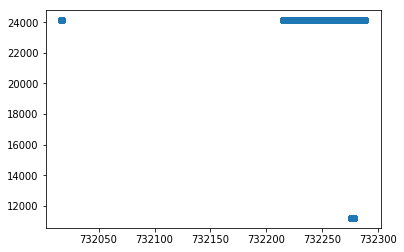

In [397]:
plt.scatter(adversaryData[np.where(adversaryData[:,2]==41)][:,0], adversaryData[np.where(adversaryData[:,2]==41)][:,1])

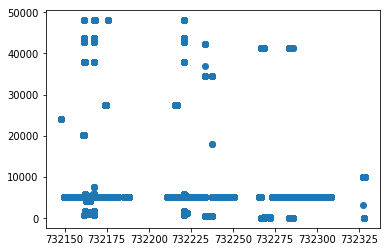

In [400]:
user = 1
plt.scatter(adversaryData[np.where(adversaryData[:,2]==user)][:,0], adversaryData[np.where(adversaryData[:,2]==user)][:,1])

Strategy 1: 
An LSTM network (one for each of 90 users). 
1. The input to each LSTM is the (time, location) of the current data point, and the history of that user [(t1, l1), (t2, l2), etc]. 
2. The output is a likelihood that the current data point belongs to that user. 
3. The outputs of each user LSTM is argmaxed to determine the most likely user. 
4. The loss function compares the predicted user to the actual user. 
5. The weights of every user LSTM is adjusted based on the loss function. 
6. The datapoint is added to the history of the user it belongs to. 
7. Repeat. 

In [ ]:
# TODO

Strategy 2: A (maybe) smarter approach.
1. Assume the first data point of each user is known.
2. For each new data point, for each user, the liklihood that this datapoint belongs to that user is a combination of: a) is it plausible based on the user's most recent location? b) is it plausible based on where this user usually visits?
3. Assign the datapoint to the most likely user.
4. At the end, compare the user bins to the true bins. Iterate over different equations for a & b.

In [279]:
def getlocallikelihood(user, u, point, offset):
    lastpoint = user[u][-1]
    deltaloc = abs(point[1] - lastpoint[1])
    deltatime = point[0] - lastpoint[0]
    if deltatime == 0 or deltaloc == 0:
        return 0
    return (-deltaloc+offset/deltatime)

def getgloballikelihood(user, u, point):
    if len(user[u]) == 1:
        return point[1] == user[u][0][1]
    count_same_loc = (user[u][:,1] == point[1]).sum()
    return count_same_loc/len(user[u])

In [280]:
def true_classify(adversaryData):
    trueuser = {}
    for point in adversaryData:
        if point[2] in trueuser.keys():
            trueuser[point[2]] = np.vstack([trueuser[point[2]], point])
        else:
            trueuser[point[2]] = point
    return trueuser

In [336]:
def classify(threshold, offset, weight_l1, weight_l2):
    num_users = 90
    user = {}
    user[0] = [adversaryData[0]]

    for point in adversaryData[1:]:
        uservec = np.zeros(len(user))
        for u in user.keys():
            l1 = getlocallikelihood(user, u, point, offset)
            l2 = getgloballikelihood(user, u, point)
            l = (weight_l1*l1+weight_l2*l2)/(weight_l1+weight_l2)
            uservec[u] = l
        if max(uservec) > threshold or len(uservec) >= num_users:
            guess = np.argmax(uservec)
            user[np.argmax(uservec)] = np.vstack([user[guess], point])
        else:
            user[max(user.keys())+1] = [point]
    return user

In [369]:
def get_loss(user, trueuser):
    u_count = []
    
    # lose points for inconsistently binned results
    loss1 = 0
    for u in user:
        if len(user[u]) != 1:
            (values,counts) = np.unique(user[u][:,2],return_counts=True)
            ind=np.argmax(counts)
            loss1 += (sum(counts) - counts[ind])
            u_count.append(values[ind])
    loss1 = loss1/len(adversaryData)
    
    # lose points for the wrong number of bins
    loss2 = (len(user)-len(trueuser))/90
    if loss2 < 0:
        loss2 = -2*loss2
    
    # lose points for bins that are redundant
    (us, counts) = np.unique(u_count, return_counts=True)
    loss3 = sum(counts - np.ones(len(counts)))/sum(counts)
    
    return 4*loss1 + loss2 + loss3

In [370]:
def printuserdict(outputuser):
    print("User Dictionary")
    for u in outputuser:
        if len(outputuser[u]) > 1:
            (values,counts) = np.unique(outputuser[u][:,2],return_counts=True)
            ind=np.argmax(counts)
            print(u, values, len(outputuser[u]))
        else:
            print(u, outputuser[u][0][2], len(outputuser[u]))

In [373]:
trueuser = true_classify(adversaryData)
best_loss = 100
for threshold in [0.01, 0.1, 1, 10, 100, 1000]:
    for offset in [0.01, 0.1, 1, 10, 100, 1000]:
        for weight_l1 in [1]:
            for weight_l2 in [1]:
# for threshold in [0.1]:
#     for offset in [100]:
#         for weight_l1 in [1]:
#             for weight_l2 in [1]:
                user = classify(threshold, offset, weight_l1, weight_l2)
                loss = get_loss(user, trueuser)
                if loss < best_loss:
                    best_loss = loss
                    print(threshold, offset, weight_l1, weight_l2, loss)
                    outputuser = user
                    printuserdict(outputuser)
                    
print("done")
# os.system('spd-say "yee"')

0.01 0.01 1 1 0.6231111111111112
User Dictionary
0 [87.] 3
1 [67.] 627
2 [67.] 225
3 [67.] 10
4 [41.] 140
5 [41. 85.] 17
6 [41.] 14
7 [85.] 435
8 [85.] 529
0.01 0.1 1 1 0.6179047619047618
User Dictionary
0 [87.] 3
1 [67.] 256
2 [67.] 599
3 [67.] 7
4 [41. 85.] 238
5 [85.] 536
6 [85.] 361
done


In [310]:
for u in trueuser:
    print(u, len(trueuser[u]))

87.0 3
67.0 862
41.0 160
85.0 975
